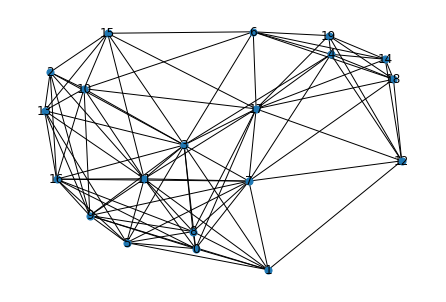

In [19]:
import networkx as nx  # Untuk membuat dan mengelola graf jaringan
import matplotlib.pyplot as plt  # Untuk visualisasi graf jaringan
import random  # Untuk memilih nilai acak, seperti energi dan pemilihan node

# Definisi kelas SensorNode dengan atribut node_id dan energy
class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node sensor dengan ID unik dan energi awal."""
        self.node_id = node_id  # ID unik untuk setiap node
        self.energy = energy  # Energi awal node

    def transmit(self, target, packet_size):
        """Mengirim paket ke node target dan mengurangi energi."""
        energy_cost = 0.1 * packet_size  # Biaya energi dihitung berdasarkan ukuran paket
        self.energy -= energy_cost  # mengurangi energi node pengirim
        target.receive(packet_size, energy_cost)  # memanggil metode receive pada node target

    def receive(self, packet_size, energy_cost):
        """Proses penerimaan paket."""
        pass

# Definisi kelas SensorNetwork untuk membuat jaringan node dan mengatur lalu lintas
class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan sensor dengan sejumlah node acak."""
        # node dengan ID dan energi acak antara 50 dan 100
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) 
                      for i in range(num_nodes)}
        
        # graf acak menggunakan random_geometric_graph dari NetworkX
        # Dengan radius 0.5, node akan dihubungkan jika jaraknya lebih dekat dari 0.5
        self.graph = nx.random_geometric_graph(num_nodes, 0.5)

    def route_packet(self, source_id, dest_id, packet_size):
        """Rute paket dari node sumber ke node tujuan."""
        # menemukan jalur dengan energi residual tertinggi 
        # Berat pada edge dihitung sebagai 1 / energi node untuk memprioritaskan node dengan energi tinggi
        path = nx.shortest_path(
            self.graph, source=source_id, target=dest_id,
            weight=lambda u, v, d: 1 / self.nodes[v].energy
        )
        # Transmisikan paket melalui jalur yang ditemukan
        for i in range(len(path) - 1):
            self.nodes[path[i]].transmit(self.nodes[path[i + 1]], packet_size)

    def simulate_traffic(self, num_packets, packet_size):
        """Simulasikan lalu lintas jaringan dengan pengiriman paket acak."""
        for _ in range(num_packets):  # mengulangi untuk setiap paket
            # memilih node sumber secara acak
            source_id = random.choice(list(self.nodes.keys()))
            # memilih node tujuan secara acak, pastikan berbeda dengan sumber
            dest_id = random.choice([n for n in self.nodes.keys() if n != source_id])
            # Rute paket dari sumber ke tujuan
            self.route_packet(source_id, dest_id, packet_size)

    def plot_network(self):
        """Visualisasikan jaringan dengan posisi setiap node."""
        # posisi node dari atribut graf
        pos = nx.get_node_attributes(self.graph, 'pos')
        # graf dengan node dan edge yang ada
        nx.draw(self.graph, pos, node_size=50, with_labels=True)
        # menampilkan plot
        plt.show()

# Inisialisasi jaringan sensor dengan 20 node
network = SensorNetwork(20)
# Simulasikan pengiriman 100 paket dengan ukuran 10
network.simulate_traffic(100, 10)
# menampilkan visualisasi jaringan
network.plot_network()


In [7]:
import heapq  # Import heap queue untuk implementasi priority queue
import random  # Import random untuk pemilihan aksi secara acak

# Definisi kelas SensorNode
class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node dengan ID dan energi awal."""
        self.node_id = node_id  # ID unik untuk node
        self.energy = energy  # Energi awal node
        self.neighbors = {}  # Dictionary untuk tetangga dan biaya komunikasi
        self.state = 'sleep'  # Status awal node (default: sleep)
        
        # Inisialisasi Q-values untuk aksi 'transmit', 'listen', dan 'sleep'
        self.q_values = {action: 0 for action in ['transmit', 'listen', 'sleep']}
        
        # Inisialisasi kebijakan awal, tiap aksi memiliki probabilitas sama (1/3)
        self.policy = {action: 1 / 3 for action in ['transmit', 'listen', 'sleep']}

    def add_neighbor(self, neighbor_node, cost):
        """Tambahkan tetangga dengan biaya komunikasi."""
        self.neighbors[neighbor_node.node_id] = cost  # Simpan tetangga dan biayanya

    def choose_action(self):
        """Pilih aksi berdasarkan kebijakan (ε-greedy exploration)."""
        actions = list(self.policy.keys())  # Daftar aksi
        probabilities = list(self.policy.values())  # Probabilitas tiap aksi
        return random.choices(actions, probabilities)[0]  # Pilih aksi secara acak sesuai kebijakan

    def update_q_value(self, action, reward, next_state_max_q_value, 
                       learning_rate=0.1, discount_factor=0.9):
        """Perbarui Q-value menggunakan formula Q-learning."""
        self.q_values[action] = (1 - learning_rate) * self.q_values[action] + \
                                learning_rate * (reward + discount_factor * next_state_max_q_value)

    def update_policy(self, exploration_rate=0.1):
        """Perbarui kebijakan dengan metode ε-greedy."""
        best_action = max(self.q_values, key=self.q_values.get)  # Temukan aksi dengan Q-value tertinggi
        for action in self.policy:
            if action == best_action:
                # Beri probabilitas lebih tinggi pada aksi terbaik
                self.policy[action] = 1 - exploration_rate + exploration_rate / len(self.q_values)
            else:
                # Beri probabilitas kecil pada aksi lainnya
                self.policy[action] = exploration_rate / len(self.q_values)

# Definisi kelas NetworkController
class NetworkController:
    def __init__(self, nodes):
        """Inisialisasi controller dengan node dalam jaringan."""
        self.nodes = nodes  # Dictionary berisi node dalam jaringan
        self.routing_table = {}  # Tabel routing untuk menyimpan jalur

    def calculate_remaining_energy(self, node):
        """Hitung energi tersisa pada node."""
        # Hitung energi node dikurangi dengan total energi tetangganya
        consumed_energy = sum([self.nodes[n].energy for n in node.neighbors])
        return node.energy - consumed_energy  # Energi tersisa

    def energy_aware_routing(self, start_node):
        """Implementasi routing energi-aware menggunakan priority queue."""
        pq = []  # Priority queue untuk pemilihan jalur terbaik
        # Masukkan node awal ke dalam queue (energi, node, jalur)
        heapq.heappush(pq, (0, start_node.node_id, [start_node.node_id]))  
        visited = set()  # Set untuk melacak node yang sudah dikunjungi

        while pq:
            # Ambil node dengan prioritas tertinggi dari queue
            current_energy, current_node_id, path = heapq.heappop(pq)  
            if current_node_id in visited:
                continue  # Lewati jika node sudah dikunjungi

            # Tandai node sebagai dikunjungi
            visited.add(current_node_id)  
            current_node = self.nodes[current_node_id]  # Dapatkan objek node
            # Simpan jalur dan energi dalam tabel routing
            self.routing_table[current_node_id] = (path, current_energy)  

            # Iterasi melalui setiap tetangga node saat ini
            for neighbor_id, cost in current_node.neighbors.items():
                if neighbor_id not in visited:  # Hanya proses tetangga yang belum dikunjungi
                    # Hitung energi baru setelah menambah biaya komunikasi
                    new_energy = current_energy + cost  
                    # Tambahkan tetangga ke queue dengan jalur yang diperbarui
                    heapq.heappush(pq, (new_energy, neighbor_id, path + [neighbor_id]))

        return self.routing_table  # Kembalikan tabel routing

    def schedule_nodes(self):
        """Jadwalkan aksi setiap node di jaringan."""
        for node in self.nodes.values():
            # Pilih aksi berdasarkan kebijakan
            action = node.choose_action()  
            # Beri reward berdasarkan aksi yang dipilih
            if action == 'transmit':
                node.state = 'transmit'
                reward = 10  # Reward untuk aksi transmit
            elif action == 'listen':
                node.state = 'listen'
                reward = 5  # Reward untuk aksi listen
            else:
                node.state = 'sleep'
                reward = 1  # Reward minimal untuk sleep

            # Perbarui Q-value dan kebijakan setelah setiap aksi
            node.update_q_value(action, reward, max(node.q_values.values()))  
            node.update_policy()  # Perbarui kebijakan berdasarkan nilai Q baru

# Inisialisasi node dengan energi awal
node1 = SensorNode(1, 100)  
node2 = SensorNode(2, 90)  
node3 = SensorNode(3, 85)  
node4 = SensorNode(4, 70)  

# Tambahkan tetangga dengan biaya komunikasi
node1.add_neighbor(node2, 10)  
node1.add_neighbor(node3, 15)  
node2.add_neighbor(node4, 20)  
node3.add_neighbor(node4, 25)  

# Buat dictionary berisi semua node
nodes = {1: node1, 2: node2, 3: node3, 4: node4}  
# Inisialisasi controller dengan node yang tersedia
controller = NetworkController(nodes)  

# Simulasi selama 10 siklus
for _ in range(10):
    controller.schedule_nodes()  # Jadwalkan aksi untuk setiap node

# Lakukan routing energi-aware dari node pertama
routing_table = controller.energy_aware_routing(node1)  

# Tampilkan tabel routing
print("Routing Table:")  
for node, (path, energy) in routing_table.items():
    print(f"Node {node}: Path = {path}, Total Energy = {energy}")  


Routing Table:
Node 1: Path = [1], Total Energy = 0
Node 2: Path = [1, 2], Total Energy = 10
Node 3: Path = [1, 3], Total Energy = 15
Node 4: Path = [1, 2, 4], Total Energy = 30


In [14]:
import random  # Import random untuk pemilihan aksi secara acak

# Definisi kelas SensorNode
class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node dengan ID dan energi awal."""
        self.node_id = node_id  # ID unik untuk node
        self.energy = energy  # Energi awal node
        self.neighbors = {}  # Tetangga dan biaya komunikasi
        self.state = 'sleep'  # Status awal node

        # Inisialisasi Q-values untuk aksi 'transmit', 'listen', 'sleep'
        self.q_values = {action: 0 for action in ['transmit', 'listen', 'sleep']}
        self.policy = {action: 1 / 3 for action in ['transmit', 'listen', 'sleep']}

    def add_neighbor(self, neighbor_node, cost):
        """Tambahkan tetangga dengan biaya komunikasi."""
        self.neighbors[neighbor_node.node_id] = cost

    def choose_action(self):
        """Pilih aksi berdasarkan kebijakan (ε-greedy exploration)."""
        actions = list(self.policy.keys())
        probabilities = list(self.policy.values())
        return random.choices(actions, probabilities)[0]

    def update_q_value(self, action, reward, next_state_max_q_value, 
                       learning_rate=0.1, discount_factor=0.9):
        """Perbarui Q-value menggunakan formula Q-learning."""
        self.q_values[action] = (1 - learning_rate) * self.q_values[action] + \
                                learning_rate * (reward + discount_factor * next_state_max_q_value)

    def update_policy(self, exploration_rate=0.1):
        """Perbarui kebijakan dengan metode ε-greedy."""
        best_action = max(self.q_values, key=self.q_values.get)
        for action in self.policy:
            if action == best_action:
                self.policy[action] = 1 - exploration_rate + exploration_rate / len(self.q_values)
            else:
                self.policy[action] = exploration_rate / len(self.q_values)

# Definisi kelas NetworkController
class NetworkController:
    def __init__(self, nodes):
        """Inisialisasi controller dengan node dalam jaringan."""
        self.nodes = nodes  # Dictionary berisi node
        self.routing_table = {}  # Tabel routing

    def energy_aware_routing(self, start_node):
        """Implementasi routing energi-aware."""
        visited = set()  # Node yang telah dikunjungi
        self._traverse(start_node, 0, [start_node.node_id], visited)

    def _traverse(self, current_node, total_energy, path, visited):
        """Traversing rekursif untuk routing energi-aware."""
        if current_node.node_id in visited:
            return

        visited.add(current_node.node_id)
        self.routing_table[current_node.node_id] = (path, total_energy)

        for neighbor_id, cost in current_node.neighbors.items():
            neighbor = self.nodes[neighbor_id]
            if neighbor_id not in visited:
                self._traverse(neighbor, total_energy + cost, path + [neighbor_id], visited)

    def schedule_nodes(self):
        """Jadwalkan aksi untuk setiap node."""
        for node in self.nodes.values():
            action = node.choose_action()
            reward = 10 if action == 'transmit' else (5 if action == 'listen' else 1)
            node.state = action
            node.update_q_value(action, reward, max(node.q_values.values()))
            node.update_policy()

# Inisialisasi node dengan energi awal
node1 = SensorNode(1, 100)
node2 = SensorNode(2, 90)
node3 = SensorNode(3, 85)
node4 = SensorNode(4, 70)

# Tambahkan tetangga dengan biaya komunikasi
node1.add_neighbor(node2, 10)
node1.add_neighbor(node3, 15)
node2.add_neighbor(node4, 20)
node3.add_neighbor(node4, 25)

# Inisialisasi jaringan
nodes = {1: node1, 2: node2, 3: node3, 4: node4}
controller = NetworkController(nodes)

# Simulasi selama 10 siklus
for _ in range(10):
    controller.schedule_nodes()

# Lakukan routing energi-aware dari node pertama
controller.energy_aware_routing(node1)

# Tampilkan tabel routing
print("Routing Table:")
for node, (path, energy) in controller.routing_table.items():
    print(f"Node {node}: Path = {path}, Total Energy = {energy}")


Routing Table:
Node 1: Path = [1], Total Energy = 0
Node 2: Path = [1, 2], Total Energy = 10
Node 4: Path = [1, 2, 4], Total Energy = 30
Node 3: Path = [1, 3], Total Energy = 15


In [17]:
import random  # Untuk pemilihan aksi secara acak

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node dengan ID dan energi awal."""
        self.node_id = node_id  # ID unik untuk node
        self.energy = energy  # Energi awal node
        self.neighbors = {}  # Tetangga dan biaya komunikasi

    def add_neighbor(self, neighbor_node, cost):
        """Tambahkan tetangga dengan biaya komunikasi."""
        self.neighbors[neighbor_node.node_id] = cost

    def transmit(self, cost):
        """Transmisikan data dan kurangi energi."""
        self.energy = max(0, self.energy - cost)

class NetworkController:
    def __init__(self, nodes):
        """Inisialisasi controller dengan node dalam jaringan."""
        self.nodes = nodes
        self.routing_table = {}  # Tabel routing untuk menyimpan jalur dan biaya

    def energy_aware_routing(self, start_node):
        """Implementasi routing energi-aware."""
        visited = set()  # Node yang telah dikunjungi
        self._traverse(start_node, 0, [start_node.node_id], visited)

    def _traverse(self, current_node, total_energy, path, visited):
        """Traversing rekursif untuk routing."""
        if current_node.node_id in visited:
            return

        visited.add(current_node.node_id)
        self.routing_table[current_node.node_id] = (path, total_energy)

        # Kurangi energi node untuk setiap langkah dalam rute
        current_node.transmit(10)  # Contoh biaya 10 unit

        for neighbor_id, cost in current_node.neighbors.items():
            neighbor = self.nodes[neighbor_id]
            if neighbor_id not in visited:
                self._traverse(neighbor, total_energy + cost, path + [neighbor_id], visited)

    def schedule_nodes(self):
        """Jadwalkan aksi dan lakukan pengiriman data."""
        for node in self.nodes.values():
            if node.energy > 0:
                node.transmit(10)  # Contoh biaya transmisi

# Inisialisasi node dengan energi awal
node1 = SensorNode(1, 100)
node2 = SensorNode(2, 90)
node3 = SensorNode(3, 85)
node4 = SensorNode(4, 70)

# Tambahkan tetangga dengan biaya komunikasi
node1.add_neighbor(node2, 10)
node1.add_neighbor(node3, 15)
node2.add_neighbor(node4, 20)
node3.add_neighbor(node4, 25)

# Inisialisasi jaringan
nodes = {1: node1, 2: node2, 3: node3, 4: node4}
controller = NetworkController(nodes)

# Simulasi selama 10 siklus
for _ in range(10):
    controller.schedule_nodes()

# Lakukan routing energi-aware dari node pertama
controller.energy_aware_routing(node1)

# Tampilkan tabel routing dan energi akhir setiap node
print("Routing Table:")
for node, (path, energy) in controller.routing_table.items():
    print(f"Node {node}: Path = {path}, Total Energy = {energy}")

print("\nSisa Energi Node:")
for node in nodes.values():
    print(f"Node {node.node_id} Energy: {node.energy}")


Routing Table:
Node 1: Path = [1], Total Energy = 0
Node 2: Path = [1, 2], Total Energy = 10
Node 4: Path = [1, 2, 4], Total Energy = 30
Node 3: Path = [1, 3], Total Energy = 15

Sisa Energi Node:
Node 1 Energy: 0
Node 2 Energy: 0
Node 3 Energy: 0
Node 4 Energy: 0


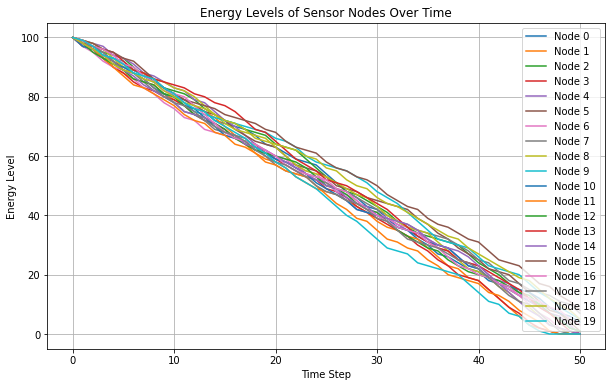

In [9]:
import matplotlib.pyplot as plt  # Untuk visualisasi grafis
import networkx as nx  # Untuk membuat graf jaringan
import random  # Untuk nilai acak

# Definisi node sensor dengan energi dan konsumsi energi
class SensorNode:
    def __init__(self, node_id, initial_energy=100):
        """Inisialisasi node dengan energi awal."""
        self.node_id = node_id  # ID unik node
        self.energy = initial_energy  # Energi awal

    def consume_energy(self, amount):
        """Konsumsi energi dengan jumlah tertentu."""
        self.energy -= amount  # Kurangi energi
        if self.energy < 0:
            self.energy = 0  # Energi tidak boleh negatif
        return self.energy  # Kembalikan energi terkini

# Definisi jaringan dengan node dan topologi acak
class Network:
    def __init__(self, size):
        """Inisialisasi jaringan dengan sejumlah node."""
        self.nodes = [SensorNode(i) for i in range(size)]  # Membuat node
        self.graph = nx.random_geometric_graph(size, 0.125)  # Graf acak

    def simulate(self, steps):
        """Simulasi konsumsi energi selama beberapa langkah."""
        energy_levels = {node.node_id: [node.energy] for node in self.nodes}  # Data energi awal
        for _ in range(steps):  # Iterasi untuk setiap langkah
            for node in self.nodes:
                # Konsumsi energi acak antara 1 dan 3 unit
                node.consume_energy(random.randint(1, 3))
                energy_levels[node.node_id].append(node.energy)  # Simpan data energi
        return energy_levels  # Kembalikan data energi

    def plot_energy(self, energy_levels):
        """Plot grafik energi setiap node selama simulasi."""
        plt.figure(figsize=(10, 6))  # Ukuran grafik
        for node_id, energies in energy_levels.items():
            plt.plot(energies, label=f'Node {node_id}')  # Plot energi setiap node
        plt.xlabel('Time Step')  # Label sumbu X
        plt.ylabel('Energy Level')  # Label sumbu Y
        plt.title('Energy Levels of Sensor Nodes Over Time')  # Judul grafik
        plt.legend()  # Tampilkan legenda
        plt.grid(True)  # Tampilkan grid
        plt.show()  # Tampilkan grafik

# Menjalankan simulasi
network_size = 20  # Jumlah node
simulation_steps = 50  # Langkah simulasi

network = Network(network_size)  # Inisialisasi jaringan
energy_levels = network.simulate(simulation_steps)  # Jalankan simulasi
network.plot_energy(energy_levels)  # Plot hasil simulasi


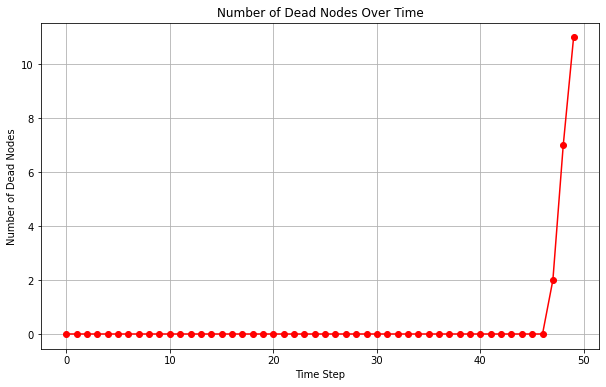

In [10]:
import matplotlib.pyplot as plt  # Untuk visualisasi
import networkx as nx  # Untuk graf jaringan
import random  # Untuk nilai acak

# Definisi node dengan status hidup/mati
class SensorNode:
    def __init__(self, node_id, initial_energy=100):
        """Inisialisasi node dengan energi awal."""
        self.node_id = node_id  # ID unik node
        self.energy = initial_energy  # Energi awal
        self.is_alive = True  # Status awal node (hidup)

    def consume_energy(self, amount):
        """Konsumsi energi dan cek status node."""
        if self.is_alive:  # Hanya konsumsi energi jika masih hidup
            self.energy -= amount  # Kurangi energi
            if self.energy <= 0:
                self.energy = 0  # Energi tidak boleh negatif
                self.is_alive = False  # Node mati
        return self.energy  # Kembalikan energi terkini

# Definisi jaringan dengan node dan topologi acak
class Network:
    def __init__(self, size):
        """Inisialisasi jaringan dengan sejumlah node."""
        self.nodes = [SensorNode(i) for i in range(size)]  # Membuat node
        self.graph = nx.random_geometric_graph(size, 0.125)  # Graf acak

    def simulate(self, steps):
        """Simulasi untuk menghitung jumlah node mati seiring waktu."""
        dead_count = []  # Data jumlah node mati
        dead_nodes = 0  # Counter node mati
        for _ in range(steps):  # Iterasi untuk setiap langkah
            for node in self.nodes:
                if node.is_alive:
                    node.consume_energy(random.randint(1, 3))  # Konsumsi energi
                    if not node.is_alive:  # Jika node mati
                        dead_nodes += 1
            dead_count.append(dead_nodes)  # Simpan jumlah node mati
        return dead_count  # Kembalikan data jumlah node mati

    def plot_dead_nodes(self, dead_count):
        """Plot grafik jumlah node mati seiring waktu."""
        plt.figure(figsize=(10, 6))  # Ukuran grafik
        plt.plot(dead_count, marker='o', linestyle='-', color='red')  # Plot data
        plt.xlabel('Time Step')  # Label sumbu X
        plt.ylabel('Number of Dead Nodes')  # Label sumbu Y
        plt.title('Number of Dead Nodes Over Time')  # Judul grafik
        plt.grid(True)  # Tampilkan grid
        plt.show()  # Tampilkan grafik

# Menjalankan simulasi
network_size = 20  # Jumlah node
simulation_steps = 50  # Langkah simulasi

network = Network(network_size)  # Inisialisasi jaringan
dead_node_count = network.simulate(simulation_steps)  # Jalankan simulasi
network.plot_dead_nodes(dead_node_count)  # Plot hasil simulasi


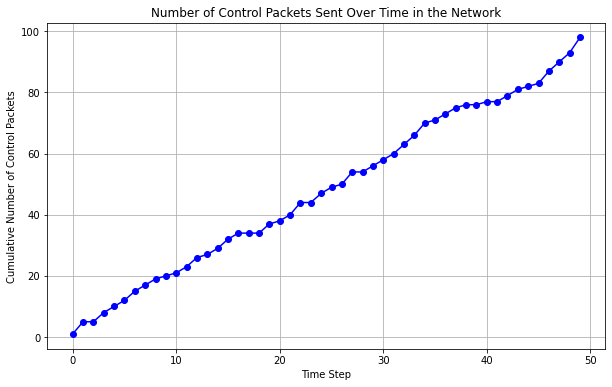

In [11]:
import matplotlib.pyplot as plt  # Untuk visualisasi grafis
import networkx as nx  # Untuk membuat graf jaringan
import random  # Untuk pemilihan acak

# Definisi node sensor dengan energi dan pengiriman paket kontrol
class SensorNode:
    def __init__(self, node_id, initial_energy=100):
        """Inisialisasi node dengan energi awal."""
        self.node_id = node_id  # ID unik node
        self.energy = initial_energy  # Energi awal
        self.is_alive = True  # Status awal (hidup)

    def consume_energy(self, amount):
        """Konsumsi energi sesuai jumlah yang diberikan."""
        if self.is_alive:  # Konsumsi hanya jika node masih hidup
            self.energy -= amount  # Kurangi energi
            if self.energy <= 0:
                self.energy = 0  # Energi tidak boleh negatif
                self.is_alive = False  # Node mati
        return self.energy  # Kembalikan energi saat ini

    def send_control_packet(self):
        """Kirim paket kontrol dengan biaya energi tetap."""
        if self.is_alive:  # Hanya kirim paket jika node hidup
            self.consume_energy(0.5)  # Biaya energi untuk mengirim paket
            return 1  # Indikator paket terkirim
        return 0  # Tidak ada paket jika node mati

# Definisi jaringan dengan node dan paket kontrol
class Network:
    def __init__(self, size):
        """Inisialisasi jaringan dengan sejumlah node."""
        self.nodes = [SensorNode(i) for i in range(size)]  # Membuat node
        self.graph = nx.random_geometric_graph(size, 0.125)  # Graf acak

    def simulate(self, steps):
        """Simulasi pengiriman paket kontrol selama beberapa langkah."""
        control_packets = []  # Data jumlah paket kontrol
        total_control_packets = 0  # Counter total paket

        for _ in range(steps):  # Iterasi untuk setiap langkah
            control_packets_this_step = 0  # Paket dalam langkah ini
            for node in self.nodes:
                if random.random() < 0.1:  # Peluang 10% untuk mengirim paket
                    control_packets_this_step += node.send_control_packet()
            total_control_packets += control_packets_this_step  # Update total paket
            control_packets.append(total_control_packets)  # Simpan data
        return control_packets  # Kembalikan data paket kontrol

    def plot_control_packets(self, control_packets):
        """Plot grafik jumlah paket kontrol yang terkirim."""
        plt.figure(figsize=(10, 6))  # Ukuran grafik
        plt.plot(control_packets, marker='o', linestyle='-', color='blue')  # Plot data
        plt.xlabel('Time Step')  # Label sumbu X
        plt.ylabel('Cumulative Number of Control Packets')  # Label sumbu Y
        plt.title('Number of Control Packets Sent Over Time in the Network')  # Judul
        plt.grid(True)  # Tampilkan grid
        plt.show()  # Tampilkan grafik

# Menjalankan simulasi
network_size = 20  # Jumlah node
simulation_steps = 50  # Langkah simulasi

network = Network(network_size)  # Inisialisasi jaringan
control_packets = network.simulate(simulation_steps)  # Jalankan simulasi
network.plot_control_packets(control_packets)  # Plot hasil simulasi


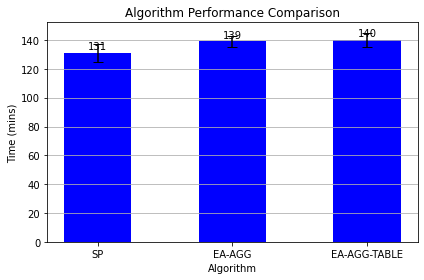

In [12]:
import matplotlib.pyplot as plt  # Untuk visualisasi grafis
import numpy as np  # Untuk operasi numerik

# Data kinerja algoritma
algorithms = ['SP', 'EA-AGG', 'EA-AGG-TABLE']  # Nama algoritma
times = [131, 139, 140]  # Waktu eksekusi (dalam menit)
errors = [6, 4, 5]  # Error atau deviasi untuk setiap algoritma

fig, ax = plt.subplots()  # Buat objek grafik

# Plot bar dengan error bar
bar_width = 0.5  # Lebar bar
x_pos = np.arange(len(algorithms))  # Posisi setiap bar
bars = ax.bar(x_pos, times, bar_width, color='blue', yerr=errors, capsize=5)  # Plot bar

# Tambahkan label dan judul grafik
ax.set_xlabel('Algorithm')  # Label sumbu X
ax.set_ylabel('Time (mins)')  # Label sumbu Y
ax.set_title('Algorithm Performance Comparison')  # Judul grafik
ax.set_xticks(x_pos)  # Posisi tick di sumbu X
ax.set_xticklabels(algorithms)  # Nama algoritma sebagai tick
ax.yaxis.grid(True)  # Tampilkan grid pada sumbu Y

# Tambahkan label nilai pada setiap bar
for bar in bars:
    yval = bar.get_height()  # Ambil tinggi bar
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, yval, 
            ha='center', va='bottom', fontsize=10)  # Tampilkan nilai

plt.tight_layout()  # Atur layout agar tidak tumpang tindih
plt.show()  # Tampilkan grafik


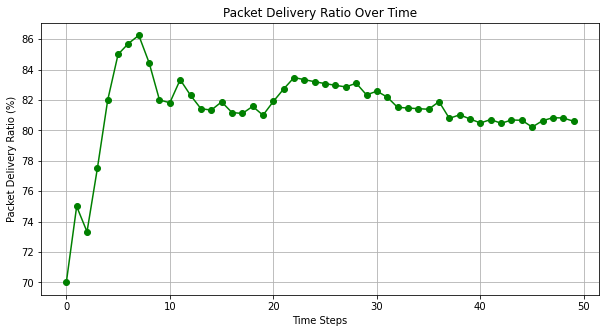

In [13]:
import matplotlib.pyplot as plt  # Untuk visualisasi
import numpy as np  # Untuk operasi numerik

# Pengaturan simulasi
total_time_steps = 50  # Jumlah langkah waktu
network_size = 20  # Jumlah node
packet_transmission_attempts_per_step = 10  # Percobaan transmisi per langkah
successful_transmission_probability = 0.8  # Peluang sukses 80%

# Data rasio pengiriman paket
packet_delivery_ratios = []  # List untuk menyimpan rasio pengiriman

successful_packets = 0  # Counter paket sukses
total_packets = 0  # Counter total paket

# Simulasi pengiriman paket
for _ in range(total_time_steps):  # Iterasi untuk setiap langkah
    successful_packets_this_step = 0  # Paket sukses dalam langkah ini
    for _ in range(packet_transmission_attempts_per_step):
        if np.random.random() < successful_transmission_probability:  # Cek peluang sukses
            successful_packets_this_step += 1  # Tambah paket sukses
    
    total_packets += packet_transmission_attempts_per_step  # Update total paket
    successful_packets += successful_packets_this_step  # Update paket sukses
    # Hitung rasio pengiriman kumulatif
    delivery_ratio = (successful_packets / total_packets) * 100  
    packet_delivery_ratios.append(delivery_ratio)  # Simpan rasio

# Plot rasio pengiriman paket
plt.figure(figsize=(10, 5))  # Ukuran grafik
plt.plot(packet_delivery_ratios, marker='o', linestyle='-', color='green')  # Plot data
plt.title('Packet Delivery Ratio Over Time')  # Judul grafik
plt.xlabel('Time Steps')  # Label sumbu X
plt.ylabel('Packet Delivery Ratio (%)')  # Label sumbu Y
plt.grid(True)  # Tampilkan grid
plt.show()  # Tampilkan grafik


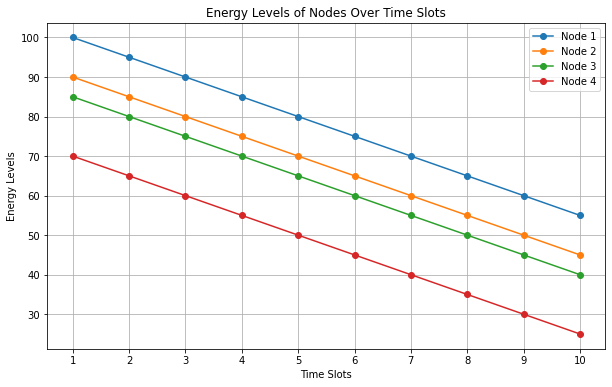

In [16]:
import matplotlib.pyplot as plt  # Untuk visualisasi grafis

# Data energi setiap node selama 10 slot waktu
time_slots = list(range(1, 11))  # Daftar slot waktu dari 1 hingga 10
node1_energy = [100, 95, 90, 85, 80, 75, 70, 65, 60, 55]  # Energi Node 1
node2_energy = [90, 85, 80, 75, 70, 65, 60, 55, 50, 45]  # Energi Node 2
node3_energy = [85, 80, 75, 70, 65, 60, 55, 50, 45, 40]  # Energi Node 3
node4_energy = [70, 65, 60, 55, 50, 45, 40, 35, 30, 25]  # Energi Node 4

# Plot energi setiap node selama slot waktu
plt.figure(figsize=(10, 6))  # Ukuran plot 10x6 inci
plt.plot(time_slots, node1_energy, label='Node 1', marker='o')  # Plot Node 1
plt.plot(time_slots, node2_energy, label='Node 2', marker='o')  # Plot Node 2
plt.plot(time_slots, node3_energy, label='Node 3', marker='o')  # Plot Node 3
plt.plot(time_slots, node4_energy, label='Node 4', marker='o')  # Plot Node 4

# Tambahkan judul dan label pada sumbu
plt.title('Energy Levels of Nodes Over Time Slots')  # Judul plot
plt.xlabel('Time Slots')  # Label sumbu X
plt.ylabel('Energy Levels')  # Label sumbu Y
plt.xticks(time_slots)  # Pastikan setiap slot waktu muncul sebagai tick di sumbu X
plt.grid(True)  # Tampilkan grid pada plot
plt.legend()  # Tampilkan legenda untuk setiap node

# Tampilkan plot tanpa mengembalikan keluaran tambahan
plt.show()


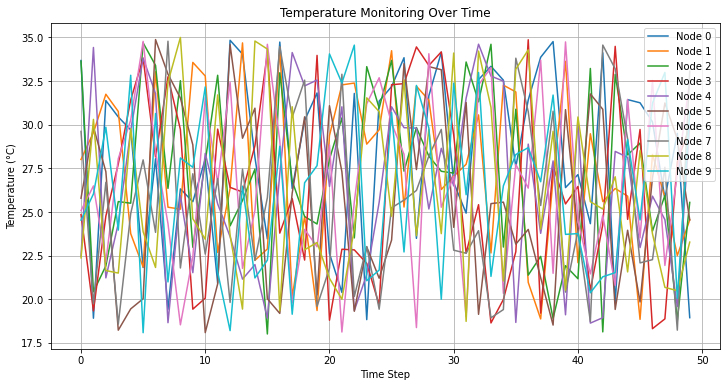

In [3]:
import matplotlib.pyplot as plt  # Untuk visualisasi data suhu
import pandas as pd  # Untuk menyimpan dan memproses data suhu
import networkx as nx  # Untuk membuat graf jaringan
import random  # Untuk memilih energi dan suhu acak

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node sensor dengan ID, energi, dan suhu awal."""
        self.node_id = node_id
        self.energy = energy
        self.temperature = random.uniform(18, 35)  # Suhu acak awal
        self.alive = True  # Status node (hidup)

    def read_temperature(self):
        """Simulasikan pembacaan suhu dari node."""
        if self.alive:
            self.temperature = random.uniform(18, 35)  # Baca suhu acak
        return self.temperature

    def transmit(self, target):
        """Kirim data suhu ke node tujuan dan kurangi energi."""
        if self.alive:
            self.energy -= 0.5  # Biaya energi
            if self.energy <= 0:
                self.alive = False  # Node mati jika energi habis
            target.receive(self.temperature)  # Kirim suhu ke target

    def receive(self, temperature):
        """Proses penerimaan data suhu (placeholder)."""
        pass

class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan sensor dengan sejumlah node."""
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) for i in range(num_nodes)}
        self.graph = nx.random_geometric_graph(num_nodes, 0.5)  # Graf acak

    def read_all_temperatures(self):
        """Baca suhu dari semua node."""
        data = {node_id: [] for node_id in self.nodes.keys()}  # Data suhu per node
        for node_id, node in self.nodes.items():
            temp = node.read_temperature() if node.alive else None  # Cek jika node hidup
            data[node_id].append(temp)  # Simpan data suhu
        return pd.DataFrame(data)  # Konversi ke DataFrame

    def route_to_sink(self, sink_id):
        """Simulasikan perutean data ke sink node."""
        for node_id, node in self.nodes.items():
            if node.alive and node_id != sink_id:
                node.transmit(self.nodes[sink_id])

    def plot_temperatures(self, temperature_df):
        """Visualisasikan data suhu dari semua node."""
        plt.figure(figsize=(12, 6))  # Ukuran plot
        for column in temperature_df.columns:  # Iterasi setiap kolom (node)
            plt.plot(temperature_df.index, temperature_df[column], label=f'Node {column}')  # Plot suhu
        plt.xlabel('Time Step')  # Label sumbu X
        plt.ylabel('Temperature (°C)')  # Label sumbu Y
        plt.title('Temperature Monitoring Over Time')  # Judul plot
        plt.legend(loc='upper right')  # Legenda
        plt.grid(True)  # Tampilkan grid
        plt.show()  # Tampilkan plot

    def simulate(self, steps, sink_id):
        """Simulasikan pemantauan suhu selama beberapa langkah waktu."""
        all_temperatures = []  # List untuk menyimpan DataFrame suhu per langkah
        for _ in range(steps):
            temp_df = self.read_all_temperatures()  # Baca suhu
            all_temperatures.append(temp_df)  # Simpan DataFrame suhu
            self.route_to_sink(sink_id)  # Simulasi perutean ke sink node
        # Gabungkan semua DataFrame suhu dan reset index
        combined_df = pd.concat(all_temperatures).reset_index(drop=True)
        return combined_df  # Kembalikan DataFrame suhu gabungan

# Inisialisasi jaringan dengan 10 node
network = SensorNetwork(10)

# Simulasikan pemantauan suhu selama 50 langkah dengan node 0 sebagai sink
temperature_data = network.simulate(50, sink_id=0)

# Visualisasikan hasil pemantauan suhu
network.plot_temperatures(temperature_data)



--- Temperature Data Table ---
            0          1          2          3          4          5  \
0   29.318052  31.312187  23.752308  20.535863  28.484003  19.052594   
1   21.666716  34.685035  18.165048  28.093419  29.760958  25.559721   
2   30.679774  28.571737  32.546695  28.269057  31.694509  21.701557   
3   30.319772  30.389654  20.239477  24.498432  20.708621  29.654106   
4   20.416873  19.332042  34.425744  30.092911  29.932641  33.255415   
5   32.418829  21.552252  22.318772  25.885184  22.663496  27.488782   
6   22.133848  32.338432  34.848929  28.189854  31.201525  20.246628   
7   26.938938  23.449153  29.776959  19.028395  24.057609  27.125295   
8   21.652023  22.820585  32.306703  21.053991  19.987170  27.878912   
9   29.328645  21.673876  23.761086  29.239163  28.447673  24.596984   
10  33.384790  25.451240  27.321226  33.318912  23.388315  33.485457   
11  22.859598  28.002929  28.903057  22.773176  27.351070  33.567421   
12  19.992537  24.308697  19.249

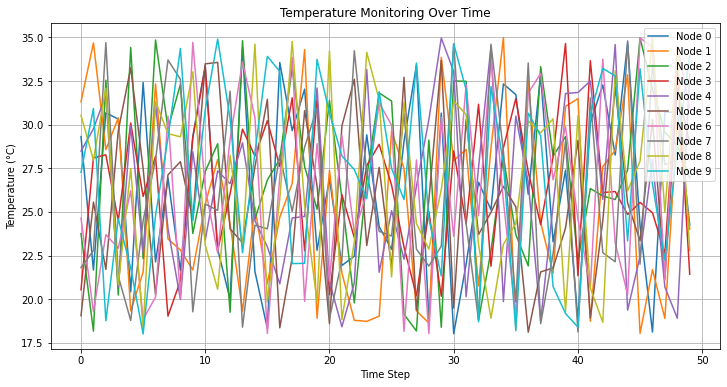

In [4]:
import matplotlib.pyplot as plt  # Untuk visualisasi data suhu
import pandas as pd  # Untuk menyimpan dan memproses data suhu
import networkx as nx  # Untuk membuat graf jaringan
import random  # Untuk memilih energi dan suhu acak

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node sensor dengan ID, energi, dan suhu awal."""
        self.node_id = node_id
        self.energy = energy
        self.temperature = random.uniform(18, 35)  # Suhu acak awal
        self.alive = True  # Status node (hidup)

    def read_temperature(self):
        """Simulasikan pembacaan suhu dari node."""
        if self.alive:
            self.temperature = random.uniform(18, 35)  # Baca suhu acak
        return self.temperature

    def transmit(self, target):
        """Kirim data suhu ke node tujuan dan kurangi energi."""
        if self.alive:
            self.energy -= 0.5  # Biaya energi
            if self.energy <= 0:
                self.alive = False  # Node mati jika energi habis
            target.receive(self.temperature)  # Kirim suhu ke target

    def receive(self, temperature):
        """Proses penerimaan data suhu (placeholder)."""
        pass

class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan sensor dengan sejumlah node."""
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) for i in range(num_nodes)}
        self.graph = nx.random_geometric_graph(num_nodes, 0.5)  # Graf acak

    def read_all_temperatures(self):
        """Baca suhu dari semua node."""
        data = {node_id: [] for node_id in self.nodes.keys()}  # Data suhu per node
        for node_id, node in self.nodes.items():
            temp = node.read_temperature() if node.alive else None  # Cek jika node hidup
            data[node_id].append(temp)  # Simpan data suhu
        return pd.DataFrame(data)  # Konversi ke DataFrame

    def route_to_sink(self, sink_id):
        """Simulasikan perutean data ke sink node."""
        for node_id, node in self.nodes.items():
            if node.alive and node_id != sink_id:
                node.transmit(self.nodes[sink_id])

    def plot_temperatures(self, temperature_df):
        """Visualisasikan data suhu dari semua node."""
        plt.figure(figsize=(12, 6))  # Ukuran plot
        for column in temperature_df.columns:  # Iterasi setiap kolom (node)
            plt.plot(temperature_df.index, temperature_df[column], label=f'Node {column}')  # Plot suhu
        plt.xlabel('Time Step')  # Label sumbu X
        plt.ylabel('Temperature (°C)')  # Label sumbu Y
        plt.title('Temperature Monitoring Over Time')  # Judul plot
        plt.legend(loc='upper right')  # Legenda
        plt.grid(True)  # Tampilkan grid
        plt.show()  # Tampilkan plot

    def simulate(self, steps, sink_id):
        """Simulasikan pemantauan suhu selama beberapa langkah waktu."""
        all_temperatures = []  # List untuk menyimpan DataFrame suhu per langkah
        for _ in range(steps):
            temp_df = self.read_all_temperatures()  # Baca suhu
            all_temperatures.append(temp_df)  # Simpan DataFrame suhu
            self.route_to_sink(sink_id)  # Simulasi perutean ke sink node
        # Gabungkan semua DataFrame suhu dan reset index
        combined_df = pd.concat(all_temperatures).reset_index(drop=True)
        return combined_df  # Kembalikan DataFrame suhu

    def display_temperature_table(self, temperature_df):
        """Tampilkan suhu dalam bentuk tabel."""
        print("\n--- Temperature Data Table ---")
        print(temperature_df)  # Cetak DataFrame dalam bentuk tabel

# Inisialisasi jaringan dengan 10 node
network = SensorNetwork(10)

# Simulasikan pemantauan suhu selama 50 langkah dengan node 0 sebagai sink
temperature_data = network.simulate(50, sink_id=0)

# Tampilkan data suhu dalam bentuk tabel
network.display_temperature_table(temperature_data)

# Visualisasikan hasil pemantauan suhu
network.plot_temperatures(temperature_data)



--- Humidity Data Table ---
            0          1          2          3          4          5  \
0   64.888338  70.074575  31.532561  77.284049  68.328225  61.351239   
1   39.743435  75.417531  43.295907  66.448738  44.809738  79.999545   
2   66.406972  41.643609  44.425542  30.542855  65.675893  46.102163   
3   38.774381  73.206484  56.613296  44.458541  39.839059  47.219061   
4   43.177706  61.798590  61.598338  64.557977  48.217206  48.520165   
5   63.655041  77.410019  71.885945  75.826687  78.948937  74.713742   
6   52.715140  73.245215  59.172521  46.052254  56.772496  54.952634   
7   67.058902  43.995211  31.398762  46.243301  53.747630  56.335733   
8   41.818453  36.996018  37.982232  40.298975  48.185753  61.009322   
9   73.111129  49.040931  76.669744  63.350868  74.297261  75.866139   
10  42.246497  34.761023  54.092082  67.663761  51.542680  78.558562   
11  64.290409  33.252022  34.274958  71.838200  51.099632  40.674941   
12  76.981915  74.016519  67.135920

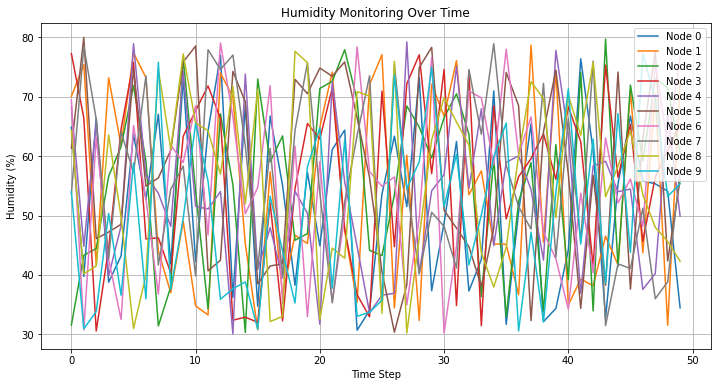

In [5]:
import matplotlib.pyplot as plt  # Untuk visualisasi data kelembaban
import pandas as pd  # Untuk menyimpan dan memproses data kelembaban
import networkx as nx  # Untuk membuat graf jaringan
import random  # Untuk memilih energi dan kelembaban acak

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node sensor dengan ID, energi, dan kelembaban awal."""
        self.node_id = node_id  # ID unik untuk setiap node
        self.energy = energy  # Energi awal node
        self.humidity = random.uniform(30, 80)  # Kelembaban awal (dalam %)
        self.alive = True  # Status node (hidup)

    def read_humidity(self):
        """Simulasikan pembacaan kelembaban dari node."""
        if self.alive:
            self.humidity = random.uniform(30, 80)  # Pembacaan kelembaban acak
        return self.humidity

    def transmit(self, target):
        """Kirim data kelembaban dan kurangi energi node."""
        if self.alive:
            energy_cost = 0.5  # Biaya energi untuk pengiriman
            self.energy -= energy_cost  # Kurangi energi pengirim
            if self.energy <= 0:
                self.alive = False  # Node mati jika energi habis
            target.receive(self.humidity)  # Node target menerima data

    def receive(self, humidity):
        """Proses penerimaan data kelembaban (placeholder)."""
        pass

class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan dengan sejumlah node."""
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) for i in range(num_nodes)}
        self.graph = nx.random_geometric_graph(num_nodes, 0.5)  # Graf acak

    def read_all_humidity(self):
        """Baca kelembaban dari semua node."""
        data = {node_id: [] for node_id in self.nodes.keys()}  # Data kelembaban per node
        for node_id, node in self.nodes.items():
            humidity = node.read_humidity() if node.alive else None  # Cek jika node hidup
            data[node_id].append(humidity)  # Simpan data kelembaban
        return pd.DataFrame(data)  # Konversi ke DataFrame

    def route_to_sink(self, sink_id):
        """Simulasi perutean data ke sink node."""
        for node_id, node in self.nodes.items():
            if node.alive and node_id != sink_id:
                node.transmit(self.nodes[sink_id])  # Kirim data ke sink

    def plot_humidity(self, humidity_df):
        """Visualisasikan data kelembaban dari semua node."""
        plt.figure(figsize=(12, 6))  # Ukuran plot
        for column in humidity_df.columns:  # Iterasi setiap kolom (node)
            plt.plot(humidity_df.index, humidity_df[column], label=f'Node {column}')  # Plot data
        plt.xlabel('Time Step')  # Label sumbu X
        plt.ylabel('Humidity (%)')  # Label sumbu Y
        plt.title('Humidity Monitoring Over Time')  # Judul plot
        plt.legend(loc='upper right')  # Legenda
        plt.grid(True)  # Tampilkan grid
        plt.show()  # Tampilkan plot

    def simulate(self, steps, sink_id):
        """Simulasi pemantauan kelembaban selama beberapa langkah waktu."""
        all_humidity = []  # List untuk menyimpan DataFrame kelembaban per langkah
        for _ in range(steps):
            humidity_df = self.read_all_humidity()  # Baca kelembaban semua node
            all_humidity.append(humidity_df)  # Simpan DataFrame
            self.route_to_sink(sink_id)  # Rute data ke sink node
        # Gabungkan semua DataFrame dan reset index
        combined_df = pd.concat(all_humidity).reset_index(drop=True)
        return combined_df  # Kembalikan DataFrame kelembaban

    def display_humidity_table(self, humidity_df):
        """Tampilkan kelembaban dalam bentuk tabel."""
        print("\n--- Humidity Data Table ---")
        print(humidity_df)  # Cetak DataFrame sebagai tabel

# Inisialisasi jaringan dengan 10 node
network = SensorNetwork(10)

# Simulasikan pemantauan kelembaban selama 50 langkah waktu dengan node 0 sebagai sink
humidity_data = network.simulate(50, sink_id=0)

# Tampilkan data kelembaban dalam bentuk tabel
network.display_humidity_table(humidity_data)

# Visualisasikan hasil pemantauan kelembaban
network.plot_humidity(humidity_data)


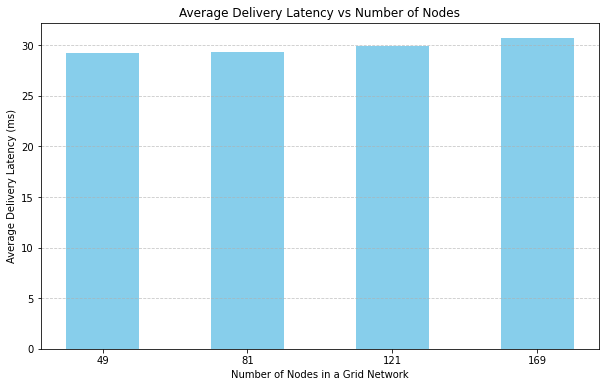

In [11]:
import matplotlib.pyplot as plt  # Untuk visualisasi data
import pandas as pd  # Untuk memproses data
import networkx as nx  # Untuk membuat graf jaringan grid
import random  # Untuk simulasi acak energi dan latensi
import numpy as np  # Untuk perhitungan rata-rata latensi

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node dengan ID dan energi awal."""
        self.node_id = node_id
        self.energy = energy
        self.alive = True  # Status hidup/mati
        self.awake = True  # Status bangun/tidur

    def decide_state(self):
        """Adaptif: Tentukan apakah node bangun atau tidur."""
        if self.energy < 20:  # Energi rendah, lebih sering tidur
            self.awake = False
        elif random.random() < 0.7:  # 70% peluang bangun
            self.awake = True
        else:
            self.awake = False  # Node tidur

    def transmit(self):
        """Simulasi pengiriman paket dengan latensi."""
        if self.awake and self.alive:  # Hanya kirim jika bangun dan hidup
            self.energy -= 1  # Kurangi energi
            if self.energy <= 0:
                self.alive = False  # Node mati jika energi habis
            return random.uniform(10, 50)  # Latensi acak 10-50 ms
        return None  # Tidak ada pengiriman jika tidur atau mati

class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan grid dengan sejumlah node."""
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) for i in range(num_nodes)}
        self.graph = nx.grid_2d_graph(int(num_nodes**0.5), int(num_nodes**0.5))  # Jaringan grid

    def simulate_latency(self, packets_per_node):
        """Simulasikan rata-rata latensi pengiriman."""
        latencies = []  # List untuk menyimpan latensi pengiriman

        for node_id, node in self.nodes.items():
            node.decide_state()  # Setiap node menentukan statusnya (tidur/bangun)
            if node.alive:  # Hanya node hidup yang bisa mengirim
                for _ in range(packets_per_node):
                    latency = node.transmit()  # Dapatkan latensi
                    if latency is not None:
                        latencies.append(latency)  # Simpan latensi

        # Hitung rata-rata latensi pengiriman
        avg_latency = np.mean(latencies) if latencies else 0
        return avg_latency  # Kembalikan rata-rata latensi

def plot_latency_vs_nodes(node_sizes, avg_latencies):
    """Visualisasikan rata-rata latensi terhadap jumlah node."""
    plt.figure(figsize=(10, 6))  # Ukuran plot
    plt.bar([str(size) for size in node_sizes], avg_latencies, color='skyblue', width=0.5)
    plt.xlabel('Number of Nodes in a Grid Network')  # Label sumbu X
    plt.ylabel('Average Delivery Latency (ms)')  # Label sumbu Y
    plt.title('Average Delivery Latency vs Number of Nodes')  # Judul grafik
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid pada sumbu Y
    plt.show()  # Tampilkan grafik

# Ukuran jaringan (49, 81, 121, 169 node)
node_sizes = [49, 81, 121, 169]
avg_latencies = []  # List untuk menyimpan rata-rata latensi

# Simulasikan latensi untuk setiap ukuran jaringan
for size in node_sizes:
    network = SensorNetwork(size)  # Buat jaringan dengan ukuran tertentu
    avg_latency = network.simulate_latency(packets_per_node=5)  # Simulasi pengiriman
    avg_latencies.append(avg_latency)  # Simpan rata-rata latensi

# Visualisasikan hasil dalam grafik batang
plot_latency_vs_nodes(node_sizes, avg_latencies)


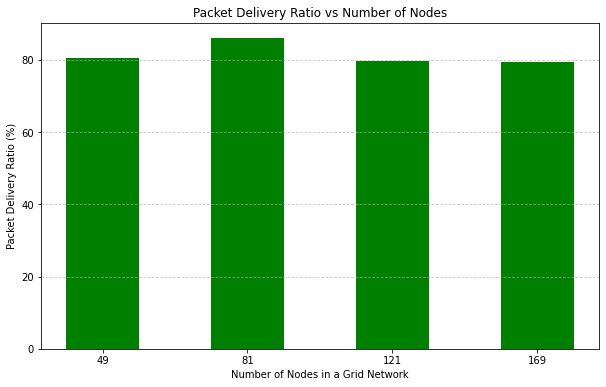


--- Packet Delivery Ratio Table ---
   Number of Nodes  Packet Delivery Ratio (%)
0               49                  80.540541
1               81                  85.964912
2              121                  79.726027
3              169                  79.491525


In [12]:
import matplotlib.pyplot as plt  # Untuk visualisasi grafik
import pandas as pd  # Untuk menyimpan dan memproses data
import networkx as nx  # Untuk membuat graf jaringan grid
import random  # Untuk energi acak dan simulasi probabilitas pengiriman paket
import numpy as np  # Untuk perhitungan rasio

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node sensor dengan ID dan energi awal."""
        self.node_id = node_id  # ID unik node
        self.energy = energy  # Energi awal
        self.alive = True  # Status hidup/mati node
        self.awake = True  # Status bangun/tidur node

    def decide_state(self):
        """Adaptif: Tentukan apakah node bangun atau tidur."""
        if self.energy < 20:  # Energi rendah, node lebih sering tidur
            self.awake = False
        elif random.random() < 0.7:  # 70% peluang tetap bangun
            self.awake = True
        else:
            self.awake = False  # Node tidur

    def transmit_packet(self):
        """Simulasi pengiriman paket dengan probabilitas keberhasilan."""
        if self.awake and self.alive:  # Hanya kirim jika bangun dan hidup
            self.energy -= 1  # Kurangi energi setiap kali mengirim
            if self.energy <= 0:
                self.alive = False  # Node mati jika energi habis
            return random.random() < 0.8  # 80% peluang pengiriman sukses
        return False  # Paket gagal jika node tidur atau mati

class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan grid dengan sejumlah node."""
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) for i in range(num_nodes)}
        self.graph = nx.grid_2d_graph(int(num_nodes**0.5), int(num_nodes**0.5))  # Jaringan grid

    def simulate_pdr(self, packets_per_node):
        """Simulasi PDR dan pengiriman paket."""
        total_packets_sent = 0  # Total paket yang dikirim
        total_packets_delivered = 0  # Total paket yang berhasil diterima

        for node_id, node in self.nodes.items():
            node.decide_state()  # Node menentukan apakah bangun atau tidur
            if node.awake and node.alive:  # Hanya node aktif yang bisa mengirim
                for _ in range(packets_per_node):
                    total_packets_sent += 1  # Hitung paket yang dikirim
                    if node.transmit_packet():  # Jika pengiriman berhasil
                        total_packets_delivered += 1  # Tambahkan paket berhasil

        # Hitung dan kembalikan PDR (%)
        pdr = (total_packets_delivered / total_packets_sent) * 100 if total_packets_sent > 0 else 0
        return pdr

def plot_pdr_vs_nodes(node_sizes, pdr_values):
    """Visualisasikan PDR dalam bentuk grafik batang."""
    plt.figure(figsize=(10, 6))  # Ukuran plot
    plt.bar([str(size) for size in node_sizes], pdr_values, color='green', width=0.5)
    plt.xlabel('Number of Nodes in a Grid Network')  # Label sumbu X
    plt.ylabel('Packet Delivery Ratio (%)')  # Label sumbu Y
    plt.title('Packet Delivery Ratio vs Number of Nodes')  # Judul grafik
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid pada sumbu Y
    plt.show()  # Tampilkan grafik

# Ukuran jaringan (49, 81, 121, 169 node)
node_sizes = [49, 81, 121, 169]
pdr_values = []  # List untuk menyimpan PDR setiap ukuran jaringan

# Simulasikan PDR untuk setiap ukuran jaringan
for size in node_sizes:
    network = SensorNetwork(size)  # Buat jaringan dengan ukuran tertentu
    pdr = network.simulate_pdr(packets_per_node=5)  # Simulasi pengiriman
    pdr_values.append(pdr)  # Simpan PDR

# Tampilkan grafik batang PDR
plot_pdr_vs_nodes(node_sizes, pdr_values)

# Tampilkan tabel PDR
pdr_df = pd.DataFrame({'Number of Nodes': node_sizes, 'Packet Delivery Ratio (%)': pdr_values})
print("\n--- Packet Delivery Ratio Table ---")
print(pdr_df)


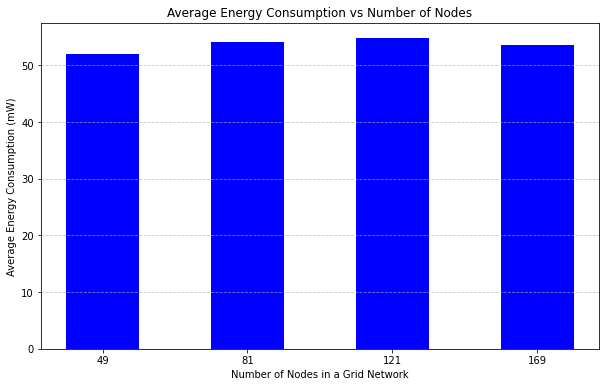


--- Average Energy Consumption Table ---
   Number of Nodes  Average Energy Consumption (mW)
0               49                        52.076347
1               81                        54.100600
2              121                        54.821466
3              169                        53.693328


In [13]:
import matplotlib.pyplot as plt  # Untuk visualisasi grafik
import pandas as pd  # Untuk memproses data
import networkx as nx  # Untuk membuat graf jaringan grid
import random  # Untuk simulasi energi dan status node
import numpy as np  # Untuk perhitungan rata-rata

class SensorNode:
    def __init__(self, node_id, energy):
        """Inisialisasi node sensor dengan ID dan energi awal."""
        self.node_id = node_id  # ID unik node
        self.energy = energy  # Energi awal node dalam mW
        self.initial_energy = energy  # Simpan energi awal untuk referensi
        self.alive = True  # Status hidup/mati node
        self.awake = True  # Status bangun/tidur node

    def decide_state(self):
        """Adaptif: Tentukan apakah node bangun atau tidur."""
        if self.energy < 20:  # Energi rendah, node lebih sering tidur
            self.awake = False
        elif random.random() < 0.7:  # 70% peluang tetap bangun
            self.awake = True
        else:
            self.awake = False  # Node tidur

    def consume_energy(self):
        """Simulasikan konsumsi energi."""
        if self.awake and self.alive:  # Hanya konsumsi energi jika bangun dan hidup
            energy_cost = random.uniform(0.5, 2.0)  # Energi terpakai (mW)
            self.energy -= energy_cost  # Kurangi energi
            if self.energy <= 0:
                self.energy = 0
                self.alive = False  # Node mati jika energi habis
            return energy_cost  # Kembalikan energi yang dikonsumsi
        return 0  # Jika node tidur, tidak ada konsumsi energi

class SensorNetwork:
    def __init__(self, num_nodes):
        """Inisialisasi jaringan grid dengan sejumlah node."""
        self.nodes = {i: SensorNode(i, random.randint(50, 100)) for i in range(num_nodes)}
        self.graph = nx.grid_2d_graph(int(num_nodes**0.5), int(num_nodes**0.5))  # Jaringan grid

    def simulate_energy_consumption(self, steps):
        """Simulasikan konsumsi energi dan hitung rata-rata konsumsi energi."""
        total_energy_consumed = 0  # Total energi terpakai

        for _ in range(steps):  # Iterasi setiap langkah waktu
            for node in self.nodes.values():
                node.decide_state()  # Node menentukan apakah bangun atau tidur
                energy_used = node.consume_energy()  # Konsumsi energi
                total_energy_consumed += energy_used  # Akumulasi energi terpakai

        # Hitung rata-rata konsumsi energi per node
        avg_energy_consumption = total_energy_consumed / len(self.nodes)
        return avg_energy_consumption  # Kembalikan rata-rata konsumsi energi

def plot_energy_vs_nodes(node_sizes, avg_energy_consumptions):
    """Visualisasikan rata-rata konsumsi energi dalam grafik batang."""
    plt.figure(figsize=(10, 6))  # Ukuran plot
    plt.bar([str(size) for size in node_sizes], avg_energy_consumptions, color='blue', width=0.5)
    plt.xlabel('Number of Nodes in a Grid Network')  # Label sumbu X
    plt.ylabel('Average Energy Consumption (mW)')  # Label sumbu Y
    plt.title('Average Energy Consumption vs Number of Nodes')  # Judul grafik
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grid pada sumbu Y
    plt.show()  # Tampilkan grafik

# Ukuran jaringan (49, 81, 121, 169 node)
node_sizes = [49, 81, 121, 169]
avg_energy_consumptions = []  # List untuk menyimpan rata-rata konsumsi energi

# Simulasikan konsumsi energi untuk setiap ukuran jaringan
for size in node_sizes:
    network = SensorNetwork(size)  # Buat jaringan dengan ukuran tertentu
    avg_consumption = network.simulate_energy_consumption(steps=100)  # Simulasi 100 langkah
    avg_energy_consumptions.append(avg_consumption)  # Simpan rata-rata konsumsi energi

# Visualisasikan hasil dalam grafik batang
plot_energy_vs_nodes(node_sizes, avg_energy_consumptions)

# Tampilkan tabel konsumsi energi
energy_df = pd.DataFrame({'Number of Nodes': node_sizes, 
                          'Average Energy Consumption (mW)': avg_energy_consumptions})
print("\n--- Average Energy Consumption Table ---")
print(energy_df)
